# Collider Bias Example: Education, Wage, and Investments

This notebook demonstrates collider bias in causal inference using synthetic data. We will show how conditioning on a collider (Investments) can bias the estimated effect of Education on Wage.

**Causal Model:**
- Education (E): Years of education (continuous)
- Wage (W): Annual wage (continuous)
- Investments (I): Amount invested (continuous)

**Causal Structure:**
- Education increases Wage (E → W)
- Both Education and Wage increase Investments (E → I ← W)

Conditioning on Investments (the collider) opens a non-causal path between Education and Wage, biasing the estimate of Education's effect on Wage.

In [114]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import warnings

np.random.seed(123)
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

## 1. Define the True Causal Model

We'll define a data-generating process where:
1. Education increases Wage
2. Both Education and Wage increase Investments
3. Investments is a collider on the path E → I ← W

We'll simulate data accordingly.

In [115]:
# Parameters
n_samples = 200
true_effect_edu_on_wage = 5.0  # True causal effect

# Generate Education (E)
edu = np.random.normal(loc=16, scale=2, size=n_samples)  # years of education

# Generate Wage (W) as a function of Education
wage = 10000 + true_effect_edu_on_wage * edu + np.random.normal(0, 80, n_samples)

# Generate Investments (I) as a function of both Education and Wage (collider)
investments = 1000 + 50 * edu + 2 * wage + np.random.normal(0, 40, n_samples)

data = pd.DataFrame({
    'education': edu,
    'wage': wage,
    'investments': investments
})

# Check the marginal regression for reference
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(data[['education']], data['wage'])
print(f"OLS marginal regression coef (should be close to true effect): {lm.coef_[0]:.2f}")

OLS marginal regression coef (should be close to true effect): 5.23


## 2. Explore the Data

Let's visualize the relationships and see the collider structure.

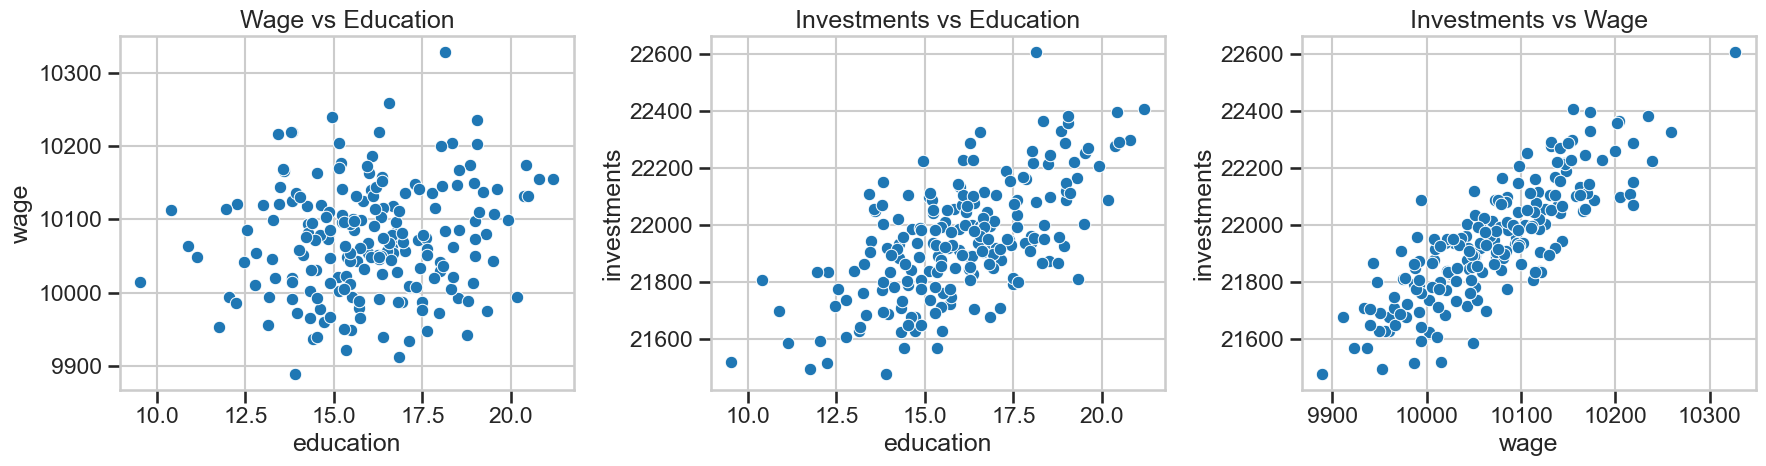

True effect of education on wage: 5.0


In [116]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=data, x='education', y='wage', ax=axes[0])
axes[0].set_title('Wage vs Education')

sns.scatterplot(data=data, x='education', y='investments', ax=axes[1])
axes[1].set_title('Investments vs Education')

sns.scatterplot(data=data, x='wage', y='investments', ax=axes[2])
axes[2].set_title('Investments vs Wage')

plt.tight_layout()
plt.show()

print("True effect of education on wage:", true_effect_edu_on_wage)

## 3. Bayesian Linear Regression Models

We'll fit two models:

1. **Unbiased model**: Wage ~ Education (does not condition on Investments)
2. **Collider-biased model**: Wage ~ Education + Investments (conditions on the collider)

We'll compare the estimated effect of Education on Wage in both cases.

In [117]:
# Standardize variables for MCMC
std_data = data.copy()
std_data['education_std'] = (data['education'] - data['education'].mean()) / data['education'].std()
std_data['wage_std'] = (data['wage'] - data['wage'].mean()) / data['wage'].std()
std_data['investments_std'] = (data['investments'] - data['investments'].mean()) / data['investments'].std()

# 1. Unbiased model (no collider)
with pm.Model() as model_unbiased:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_edu = pm.Normal('beta_edu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=5)
    mu = alpha + beta_edu * std_data['education_std']
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=std_data['wage_std'])
    trace_unbiased = pm.sample(3000, tune=1000, return_inferencedata=True)

# 2. Collider-biased model (conditions on investments)
with pm.Model() as model_collider:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_edu = pm.Normal('beta_edu', mu=0, sigma=10)
    beta_inv = pm.Normal('beta_inv', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=5)
    mu = alpha + beta_edu * std_data['education_std'] + beta_inv * std_data['investments_std']
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=std_data['wage_std'])
    trace_collider = pm.sample(3000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_edu, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_edu, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_edu, beta_inv, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_edu, beta_inv, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


## 4. Compare Model Results

Let's compare the posterior distributions of the education effect from both models and see the collider bias.

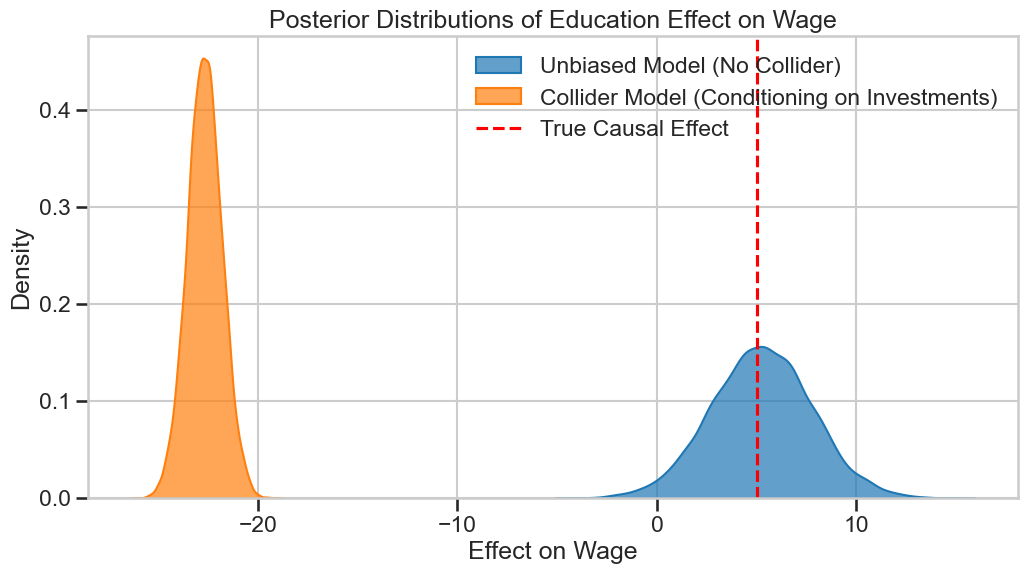

Unbiased model effect estimate: 5.23 (95% CI: [0.25, 10.28])
Collider model effect estimate: -22.68 (95% CI: [-24.39, -20.96])
True causal effect: 5.00


In [118]:
# Extract posterior samples
unbiased_effect = trace_unbiased.posterior['beta_edu'].values.flatten()
collider_effect = trace_collider.posterior['beta_edu'].values.flatten()

# Rescale to original units
std_wage = data['wage'].std()
std_edu = data['education'].std()
unbiased_effect_rescaled = unbiased_effect * std_wage / std_edu
collider_effect_rescaled = collider_effect * std_wage / std_edu

plt.figure(figsize=(12, 6))
sns.kdeplot(unbiased_effect_rescaled, fill=True, label='Unbiased Model (No Collider)', alpha=0.7)
sns.kdeplot(collider_effect_rescaled, fill=True, label='Collider Model (Conditioning on Investments)', alpha=0.7)
plt.axvline(x=true_effect_edu_on_wage, color='red', linestyle='--', label='True Causal Effect')
plt.title('Posterior Distributions of Education Effect on Wage')
plt.xlabel('Effect on Wage')
plt.ylabel('Density')
plt.legend()
plt.show()

print("Unbiased model effect estimate: {:.2f} (95% CI: [{:.2f}, {:.2f}])".format(
    unbiased_effect_rescaled.mean(),
    np.percentile(unbiased_effect_rescaled, 2.5),
    np.percentile(unbiased_effect_rescaled, 97.5)
))

print("Collider model effect estimate: {:.2f} (95% CI: [{:.2f}, {:.2f}])".format(
    collider_effect_rescaled.mean(),
    np.percentile(collider_effect_rescaled, 2.5),
    np.percentile(collider_effect_rescaled, 97.5)
))

print("True causal effect: {:.2f}".format(true_effect_edu_on_wage))

## 5. Visualize the Posterior Traces

Let's check the MCMC traces for both models.

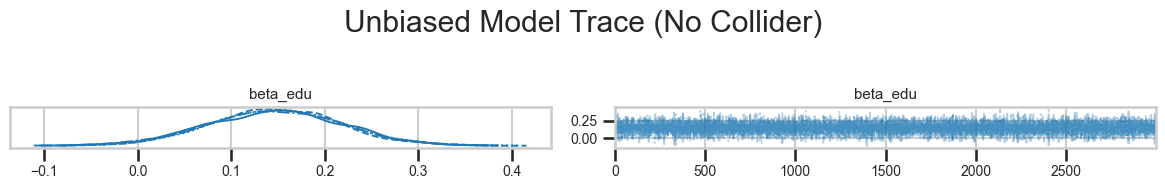

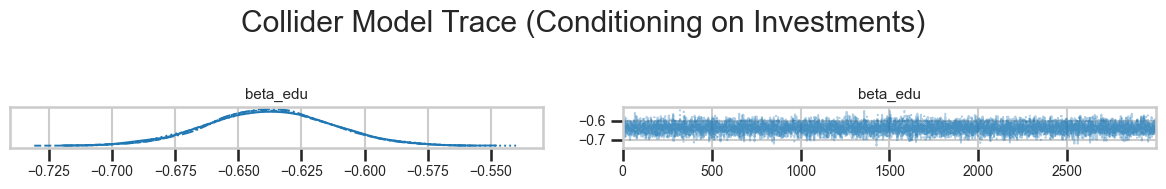

In [119]:
az.plot_trace(trace_unbiased, var_names=['beta_edu'])
plt.suptitle('Unbiased Model Trace (No Collider)')
plt.tight_layout()
plt.show()

az.plot_trace(trace_collider, var_names=['beta_edu'])
plt.suptitle('Collider Model Trace (Conditioning on Investments)')
plt.tight_layout()
plt.show()

## 6. Conclusions

- **Unbiased model (no collider):** The estimated effect of education on wage is close to the true causal effect.
- **Collider model (conditioning on investments):** The estimated effect is biased due to collider bias. Conditioning on investments opens a non-causal path between education and wage.

This example demonstrates that **conditioning on a collider can introduce bias** in causal inference. Always consider the causal structure before including variables in your model.